In [1]:
import tensorflow as tf
import os
import hickle as hkl
import numpy as np

In [2]:

%run ../src/preprocessing/indices.py

In [3]:
predict_model_path = "../models/224-TEST/"
predict_graph_def = tf.compat.v1.GraphDef()

min_all = [0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 
               0.013351644159609368, 0.01965362020294499, 0.014229037918669413, 
               0.015289539940489814, 0.011993591210803388, 0.008239871824216068,
               0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101,
               -0.4973397113668104, -0.09731556326714398, -0.7193834232943873]

max_all = [0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 
           0.6027466239414053, 0.5650263218127718, 0.5747005416952773,
           0.5933928435187305, 0.6034943160143434, 0.7472037842374304,
           0.7000076295109483, 0.509269855802243, 0.948334642387533, 
           0.6729257769285485, 0.8177635298774327, 0.35768999002433816,
           0.7545951919107605, 0.7602693339366691]

min_all = np.array(min_all)
max_all = np.array(max_all)

midrange = (max_all + min_all) / 2

midrange = midrange.astype(np.float32)
rng = max_all - min_all
rng = rng.astype(np.float32)

print(f"Loading model from {predict_model_path}")
predict_file = tf.io.gfile.GFile(predict_model_path + "predict_graph.pb", 'rb')
predict_graph_def.ParseFromString(predict_file.read())
predict_graph = tf.import_graph_def(predict_graph_def, name='predict')
predict_sess = tf.compat.v1.Session(graph=predict_graph)
predict_feats = predict_sess.graph.get_tensor_by_name(f"predict/csse_out_mul/mul:0") 
predict_logits = predict_sess.graph.get_tensor_by_name(f"predict/conv2d_13/Sigmoid:0") 


predict_inp = predict_sess.graph.get_tensor_by_name("predict/Placeholder:0")
predict_length = predict_sess.graph.get_tensor_by_name("predict/PlaceholderWithDefault:0")

Loading model from ../models/224-TEST/


In [15]:
def predict_subtile(subtile: np.ndarray, sess: "tf.Sess", op) -> np.ndarray:
    """ Runs temporal (convGRU + UNET) predictions on a (12, 216, 216, 17) array:
        - Calculates remote sensing indices
        - Normalizes data
        - Returns predictions for subtile

        Parameters:
         subtile (np.ndarray): monthly sentinel 2 + sentinel 1 mosaics
         sess (tf.Session): tensorflow session for prediction
    
        Returns:
         preds (np.ndarray): (160, 160) float32 [0, 1] predictions
    """
    #np.save('subtile.npy', subtile)
    if np.sum(subtile) != 0:
        if not isinstance(subtile.flat[0], np.floating):
            print("CONVERTING TO FLOAT")
            assert np.max(subtile) > 1
            subtile = subtile / 65535.

        time1 = time.time()
        subtile = np.core.umath.clip(subtile, min_all, max_all)
        subtile = (subtile - midrange) / (rng / 2)
        batch_x = subtile[np.newaxis].astype(np.float32)
        lengths = np.full((batch_x.shape[0]), 12)
        time2 = time.time()

        time1 = time.time()
        preds = sess.run(op,
                              feed_dict={predict_inp:batch_x, 
                                         predict_length:lengths})

        preds = preds.squeeze()
        preds = preds[1:-1, 1:-1]
        time2 = time.time()

    else:
        preds = np.full((SIZE, SIZE), 255)
        print(f"The sum of the subtile is {np.sum(subtile)}")
    
    return preds

In [90]:
def predict_out(subtile, sess, op):
    lengths = np.full((1), 12)
    preds = sess.run(op,
                          feed_dict={predict_inp:subtile, 
                                     predict_length:lengths})

    preds = preds.squeeze()
    return preds



In [91]:
x = np.load("../src/subtile.npy")

<AxesSubplot:>

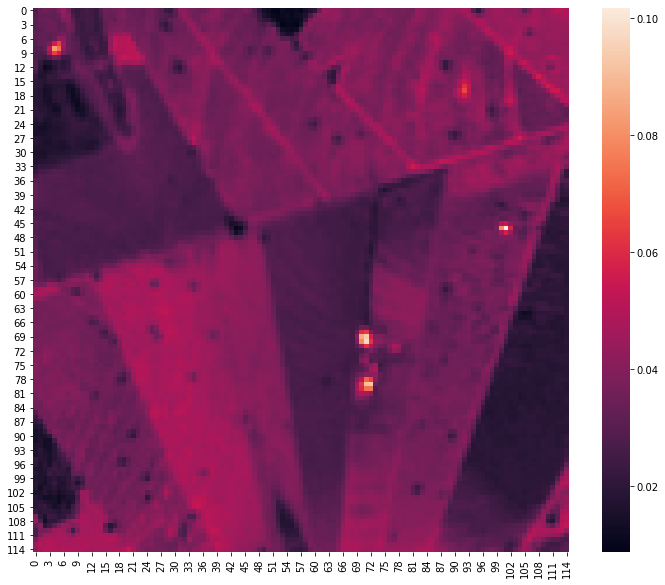

In [92]:
import seaborn as sns

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))


sns.heatmap(x[0, -122:-7, -122:-7, 0])

<AxesSubplot:>

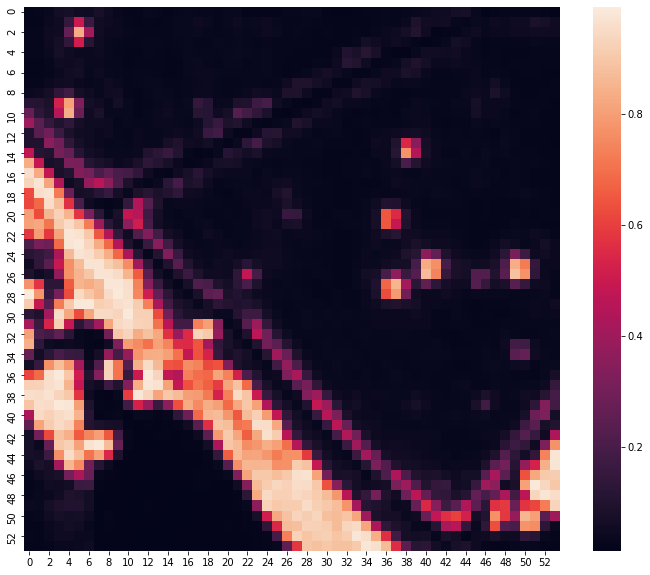

In [135]:
import time
l = predict_subtile(x, predict_sess, predict_logits)
#l = predict_out(l, predict_sess, predict_logits)
#l[l < 0.3] = 0.
#l[l >= 0.3] = 1.
plt.figure(figsize=(12, 10))
sns.heatmap(l[:54, :54])


<AxesSubplot:>

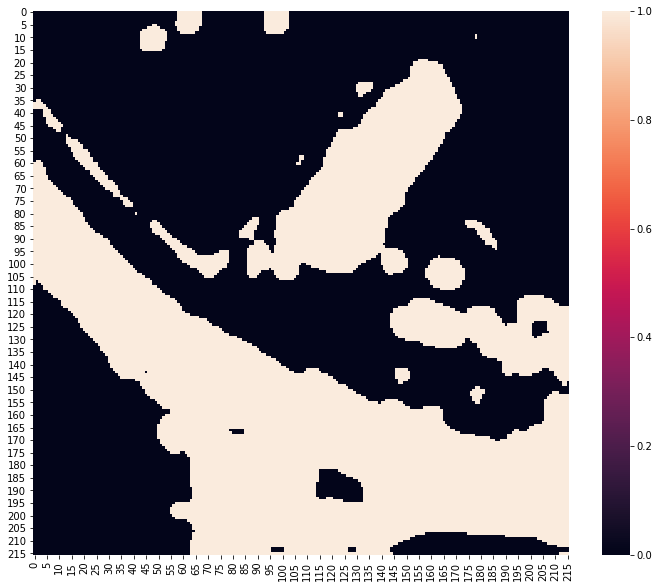

In [140]:
import skimage.transform
plt.figure(figsize=(12, 10))


f = skimage.transform.resize(l[25:80, 25:80:], (216, 216), 1)
f[f > 0.3] = 1.
f[f < 0.3] = 0.
sns.heatmap(f)

In [102]:
l = predict_subtile(x, predict_sess, predict_feats)
#l = np.pad(l, ((1, 1), (1, 1), (0, 0)))
np.save("feats.npy", l)

<AxesSubplot:>

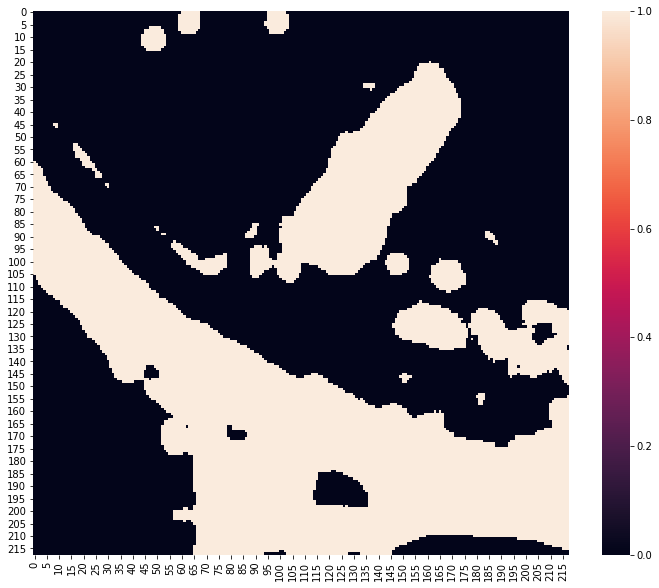

In [122]:
f = np.load("feats_sup.npy").squeeze()
f = f[100:318, 100:318]
plt.figure(figsize=(12, 10))
preds = predict_sess.run(predict_logits, {predict_feats: f[np.newaxis]})
preds[preds < 0.3] = 0.
preds[preds >= 0.3] = 1.
sns.heatmap(preds.squeeze())

<AxesSubplot:>

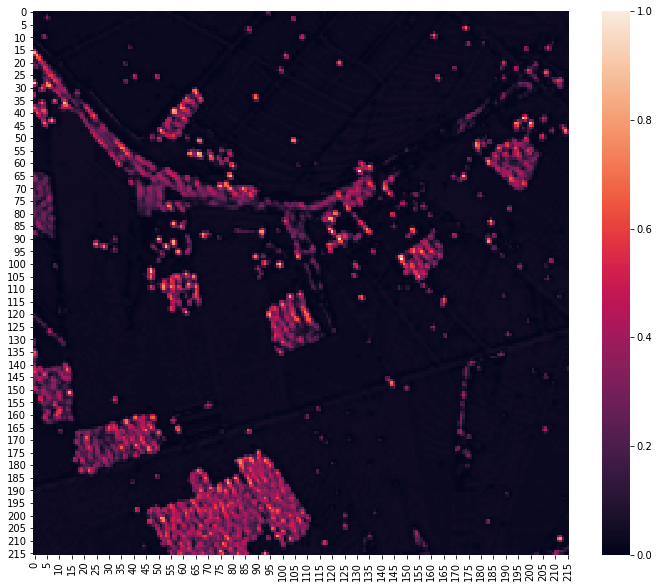

In [80]:
plt.figure(figsize=(12, 10))
sns.heatmap(l[..., 0], vmin = 0, vmax = 1)

In [43]:
import skimage.transform
x2 = x
x2 = skimage.transform.resize(x, (13, 230*2, 230*2, 17), 2)
#x2 = x2.repeat(2, axis = 1).repeat(2, axis = 2)
print(x2.shape)
x2 = x2[:, -230:, -230:, :]


"""
print(x2.shape)

supres = np.load("supres.npy").squeeze()
print(supres.shape)
supres = supres.reshape((13, 460, 2, 460, 2, 8))
supres = np.mean(supres, axis = (2, 4))
x2[..., :8] = supres[:, -230:, -230:, :]

x2[..., -4] = evi(x2)
x2[..., -3] = bi(x2)
x2[..., -2] = msavi2(x2)
x2[..., -1] = grndvi(x2)
"""

(13, 460, 460, 17)


'\nprint(x2.shape)\n\nsupres = np.load("supres.npy").squeeze()\nprint(supres.shape)\nsupres = supres.reshape((13, 460, 2, 460, 2, 8))\nsupres = np.mean(supres, axis = (2, 4))\nx2[..., :8] = supres[:, -230:, -230:, :]\n\nx2[..., -4] = evi(x2)\nx2[..., -3] = bi(x2)\nx2[..., -2] = msavi2(x2)\nx2[..., -1] = grndvi(x2)\n'

In [40]:
import time
l = predict_subtile(x2[:, -230:, -230:, :], predict_sess)

<AxesSubplot:>

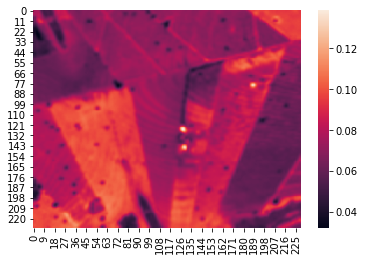

In [41]:
sns.heatmap(x2[1, ..., 1])

<AxesSubplot:>

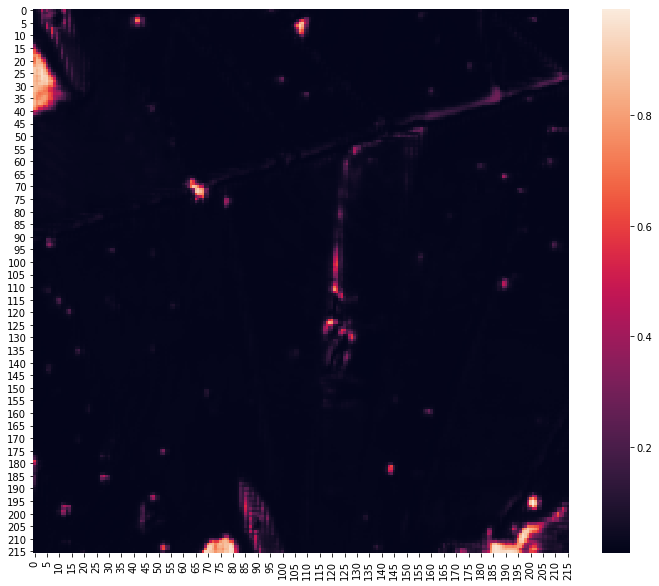

In [28]:
# Super resolved
plt.figure(figsize=(12, 10))
#l[l < 0.2] = 0.
#l = np.reshape(l, (108, 2, 108, 2))
#l = np.mean(l, axis = (1, 3))
sns.heatmap(l)

<AxesSubplot:>

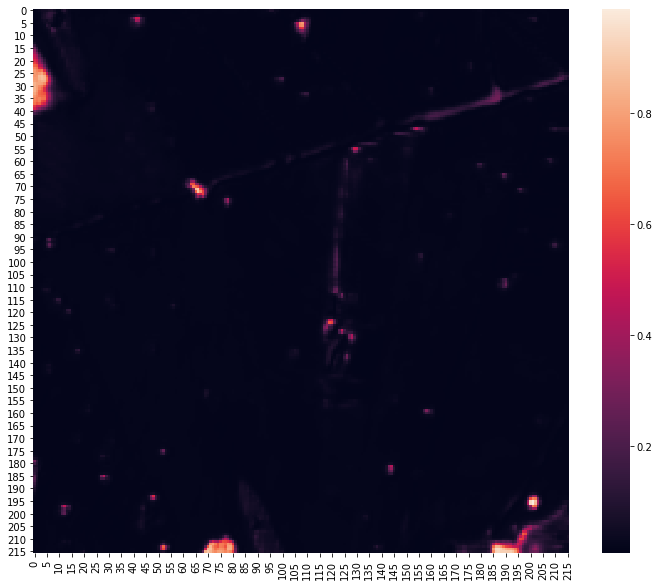

In [42]:
# NEAREST NEIGHBOR
plt.figure(figsize=(12, 10))
sns.heatmap(l)

<AxesSubplot:>

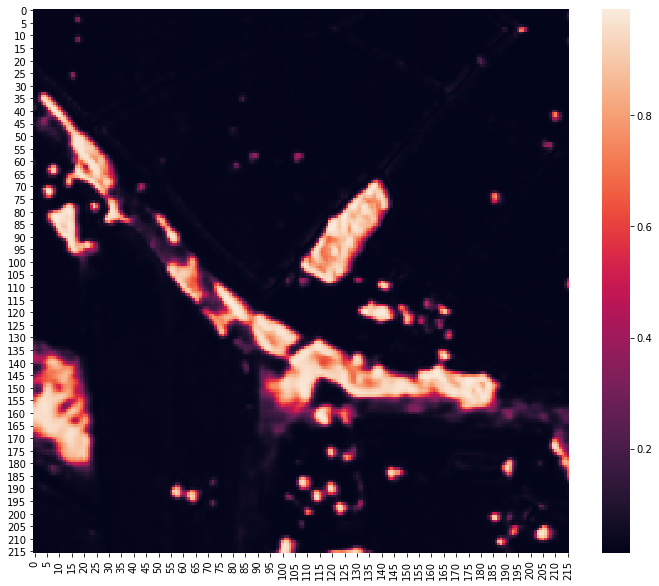

In [32]:
# BICUBIC
plt.figure(figsize=(12, 10))
sns.heatmap(l)